In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
working_dir = os.path.expanduser('~/workspace/theislab/mubind/docs/notebooks/scatac')
if os.path.exists(working_dir):
    os.chdir(working_dir)

In [4]:
pwd

'/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac'

In [5]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [6]:
atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_sample_10000.h5ad'
os.path.exists(atac_path)

True

In [7]:
import scanpy as sc
adata = sc.read_h5ad(atac_path)

In [8]:
adata.shape

(10000, 10000)

In [9]:
n_sample_cells = 1000
n_sample_peaks = 1000

In [10]:
adata.shape

(10000, 10000)

In [11]:
adata = adata[:,adata.var.modality == 'ATAC'].copy()
obs_sample = pd.Series(adata.obs_names).sample(n_sample_cells)
var_sample = pd.Series(adata.var_names).sample(n_sample_peaks)

adata = adata[adata.obs_names.isin(obs_sample),adata.var_names.isin(var_sample)]

In [12]:
adata.shape

(1000, 1000)

In [13]:
adata.shape

(1000, 1000)

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


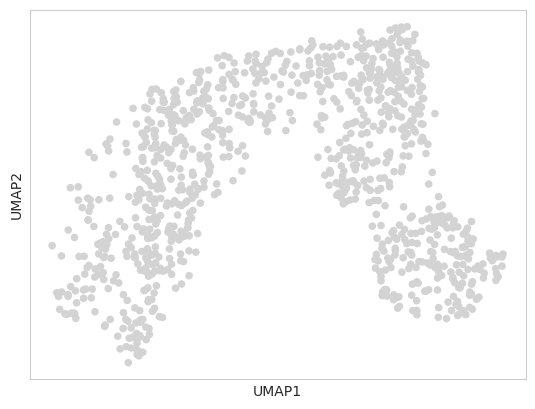

In [14]:
sc.pl.umap(adata)

In [15]:
adata.var

,modality
1-4142239-4143129,ATAC
1-9742682-9743370,ATAC
1-13935685-13936597,ATAC
1-16252795-16253197,ATAC
1-16309056-16309913,ATAC
...,...
X-150657026-150657907,ATAC
X-152089565-152090490,ATAC
X-155203714-155204585,ATAC
X-157378563-157379491,ATAC


In [16]:
adata.var['chr'] = 'chr' + adata.var_names.str.split('-').str[0]
adata.var['start'] = adata.var_names.str.split('-').str[1].astype(int)
adata.var['end'] = adata.var_names.str.split('-').str[2].astype(int)

/tmp/ipykernel_14540/2332568260.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['chr'] = 'chr' + adata.var_names.str.split('-').str[0]


In [17]:
extend = 50

adata.var['chr'].value_counts()

chr1     86
chr5     76
chr2     67
chr9     65
chr8     64
chr11    62
chr6     54
chr4     53
chr7     51
chr3     50
chr13    47
chr14    45
chr10    42
chr12    42
chr16    40
chr17    40
chr15    33
chr18    31
chr19    31
chrX     21
Name: chr, dtype: int64

In [18]:
adata.var['summit'] = ((adata.var['end'] + adata.var['start']) / 2).astype(int)
adata.var['summit.start'] = adata.var['summit'] - extend
adata.var['summit.end'] = adata.var['summit'] + extend

In [19]:
adata.var['k.summit'] = adata.var['chr'] + ':' + adata.var['summit.start'].astype(str) + '-' + adata.var['summit.end'].astype(str)

In [20]:
adata.shape

(1000, 1000)

In [21]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa')
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

/tmp/tmp19272q5_
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmp19272q5_ -fo /tmp/tmpeidw46cs


In [22]:
len(seqs)

1000

In [23]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.T

In [24]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)
# next_data = pd.DataFrame.sparse.from_spmatrix(counts)# var = []
# for ri, r in next_data.iterrows():
#     if ri % 1000 == 0:
#         print(ri, next_data.shape)
#     # print(ri, r.values[:-1], r.values[:-1].var())
#     var.append(r.values[:-1].var())
#     # break


next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

next_data_sel

del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(999, 1000)

In [25]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [26]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(999000, 3)
1000
0      999
137    999
127    999
128    999
129    999
      ... 
69     999
70     999
71     999
72     999
199    999
Name: batch, Length: 200, dtype: int64


,0,1,batch
seq,,,
GCCCAATGAAGCGCGAGTTCCACCTTCTCGGGGCGGCTCTAGGATGAGAGTGACGGCTCTGATCAGTCACGTGGCCTTGAGGGCGGAGCCTATGAAAATT,1.0,0.0,0
GCTCACTACCAAGACCCCGCCTCCTCAGAAGAGCTTCACCGGAAGAGCAGTTCGCTGCAGGCCCCGCCCACATTTCTTGGGATCCGTTCTGAAAACAGCA,1.0,0.0,0
GTACCACGCGGGAGGCCGTGAGGGAGCGCGGCGAGGGCGGGGCGAGGGCGGGGCGAGCGACGCAATTGGCCCGCGCAGCTGAACAGGGAACTTTAGCGAT,1.0,5.0,0
CCAGGAGGCCACACTTCCTCGACTTCCTGGCGCTGGGCCTTATGGGATCTGTAGTGTCCCGAGAGCCGCCACAGTATCCTCAGACGCCGCCCCGAGGGGA,1.0,1.0,0
CCTCCGCGGAGACCCCCGCCCACTCCACACACTCTCCCATCATGCAGCGGGGAACCGCTGCTGTCCATACGTCACTTCCGGGCGCAGGTGGCTAGGTCGG,1.0,1.0,0


### This is the relatedness graph and used for dynamics filters learning

In [27]:
# sum(adata.obs_names.isin(df.index)

In [28]:
len(seqs)

1000

In [29]:
conn_sparse = adata[:,~zero_counts].uns['neighbors']['connectivities']
conn_sparse

/tmp/ipykernel_14540/575103116.py:1: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  conn_sparse = adata[:,~zero_counts].uns['neighbors']['connectivities']


<1000x1000 sparse matrix of type '<class 'numpy.float32'>'
	with 1410 stored elements in Compressed Sparse Row format>

In [30]:
rel = conn_sparse.A
# rel[:n_cells,:n_cells].sum()
rel.shape

(1000, 1000)

In [31]:
# df2 = []
# for i in df.columns:
#     df3 = df[[i]].copy()
#     df3 = df3.head(100)
#     df3.columns = [0]
#     df3[1] = 1 # need a minimal non-zero count
#     df3['batch'] = i
#     df2.append(df3)
# df2 = pd.concat(df2)
# # df2['is_count_data'] = True
# dataset = mb.datasets.SelexDataset(df2, n_rounds=2, labels=[0, 1], enr_series=False)
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

1

In [32]:
n_batch = len(set(dataset.batch))
n_batch

1

In [33]:
# df = next_data_sel.copy()
# dataset = mb.datasets.GenomicsDataset(df)
# train = tdata.DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [34]:
# log_etas = torch.tensor(np.log(df.sum(axis=0) / df.sum().sum())).reshape(1, n_batch).to(device)
# log_etas

In [35]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [36]:
n_kernels = 5

In [37]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")

criterion = mb.tl.PoissonLoss()

w = [20 for i in range(n_kernels - 2)]
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=False,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None).cuda()

# Init
def triu_init(m):
    with torch.no_grad():
        m.weight.copy_(torch.triu(m.weight))

# Zero out gradients
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask

    return hook



In [38]:
# Init
def triu_init(m):
    with torch.no_grad():
        m.weight.copy_(torch.triu(m.weight))

# Zero out gradients
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask

    return hook

import torch.nn as tnn
model.selex_module.conn_sparse = torch.tensor(adata[:, ~zero_counts].uns['neighbors']['connectivities'].A).to_sparse().requires_grad_(True).cuda()
model.selex_module.log_dynamic = tnn.Parameter(torch.rand(model.selex_module.conn_sparse.indices().shape[1])) # .cuda()
model = model.cuda()
model.selex_module.log_dynamic.shape

mask = torch.tril(torch.ones_like(model.selex_module.log_dynamic), -1)
# print(mask.device)
# print(model.selex_module.log_dynamic)
model.selex_module.log_dynamic.register_hook(get_zero_grad_hook(mask))
# # here we set up the relationships between cells using the knn graph, for graph-based learning of activities
# model.selex_module.conn_sparse = torch.tensor(rel).cuda().to_sparse()

In [39]:
%load_ext line_profiler

In [40]:
# %lprun -f model.selex_module.forward model.optimize_iterative(train, n_epochs=[500] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False)

In [41]:
model, best_loss = model.optimize_iterative(train, n_epochs=[500] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0] + [0] * (n_kernels - 2),
                                            opt_kernel_length=[0, 0] + [0] * (n_kernels - 2),
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20] * (n_kernels - 2), r2_per_epoch=True,
                                            exp_max=8,
                                            # skip_kernels=range(3, 100),
                                            early_stopping=50, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 500 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
Epoch: 11, Loss: 0.229492, R2: 0.30,  best epoch: 9,  secs per epoch: 0.280 s,  secs epoch*1k trials: 0.281s
Epoch: 21, Loss: 0.227215, R2: 0.31,  best epoch: 19,  secs per epoch: 0.204 s,  secs epoch*1k trials: 0.204s
Epoch: 31, Loss: 0.225565, R2: 0.32,  best epoch: 29,  secs per epoch: 0.169 s,  secs epoch*1k trials: 0.169s
Epoch: 41, Loss: 0.224367, R2: 0.33,  best epoch: 39,  secs per epoch: 0.153 s,  secs epoch*1k trials: 0.153s
Epoch: 51, Loss: 0.223494, R2: 0.34,  best epo

In [42]:
n_cols = len(model.binding_modes)

True
2


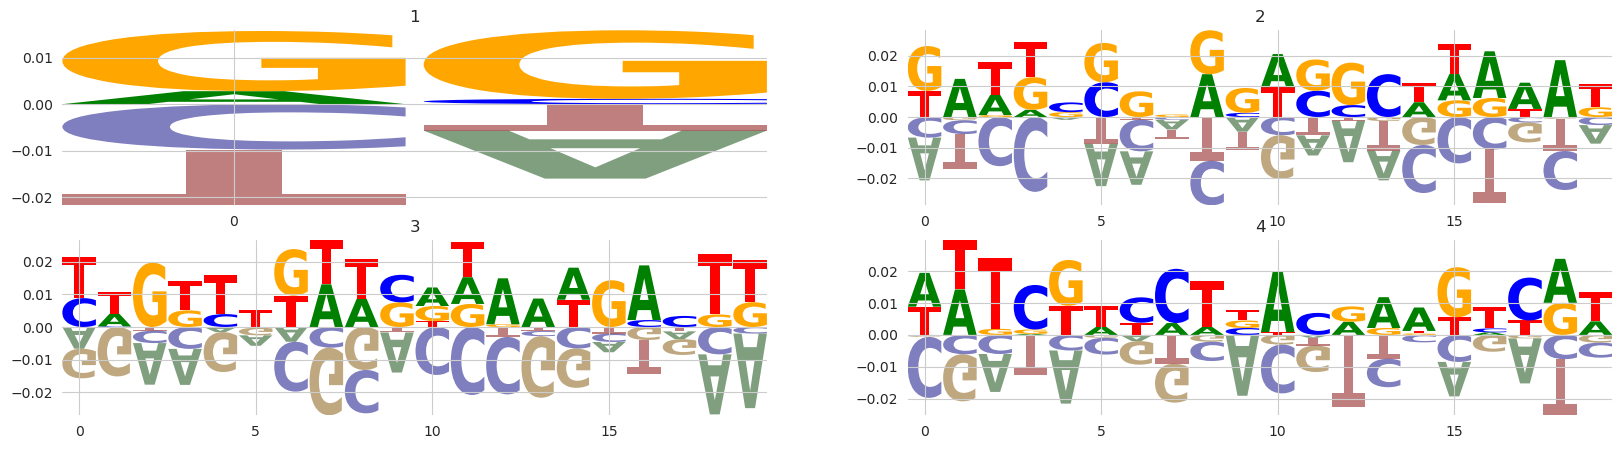

In [43]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=int(n_cols / 2), n_rows=2, show=True)
plt.show()


In [44]:
# log_dynamic = model.selex_module.log_dynamic
# print(log_dynamic)
# log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)


In [45]:
tsum = torch.sum
texp = torch.exp
tspa = torch.sparse_coo_tensor
tsmm = torch.sparse.mm
t = torch.transpose

# connectivities
C = model.selex_module.conn_sparse
a_ind = C.indices()

log_dynamic = model.selex_module.log_dynamic
D = model.selex_module.log_dynamic
D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
D = D_tril + t(D_triu, 0, 1)
# log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
D

tensor(indices=tensor([[  0,   0,   1,  ..., 590, 602, 657],
                       [167, 324,   7,  ..., 998, 998, 998]]),
       values=tensor([ 0.1916,  0.6789,  0.0963,  ..., -0.8822, -0.4848,
                      -0.4593]),
       device='cuda:0', size=(1000, 1000), nnz=2820, layout=torch.sparse_coo,
       grad_fn=<AddBackward0>)

In [46]:
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
log_dynamic

Parameter containing:
tensor([0.1916, 0.6789, 0.0963,  ..., 0.8822, 0.4848, 0.4593], device='cuda:0',
       requires_grad=True)

In [47]:
log_dynamic.max()

tensor(0.9997, device='cuda:0', grad_fn=<MaxBackward1>)

<AxesSubplot: >

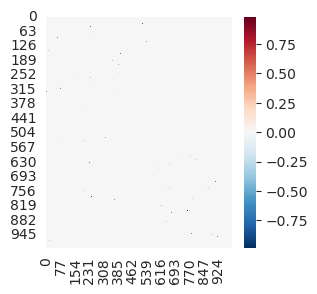

In [48]:
import seaborn as sns
mb.pl.set_rcParams({'figure.figsize': [3, 3]})
sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')

<AxesSubplot: xlabel='index', ylabel='r2'>

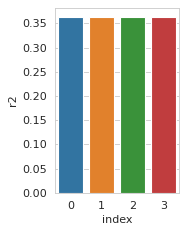

In [49]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
sns.barplot(data=r2, x='index', y='r2')

In [50]:
torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)


In [51]:

# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
adata.obs['dynamic_score'] = dynamic_score

Text(0.5, 7.555555555555548, 'dynamic score (normalized)')

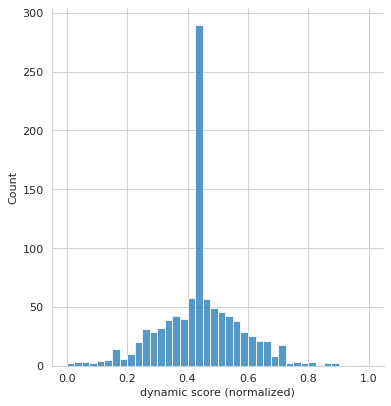

In [52]:
adata.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

adata.obs['dynamic_score_z1'] = z1
adata.obs['dynamic_score_z2'] = z2

#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
sns.displot(dynamic_score)
plt.xlabel('dynamic score (normalized)')


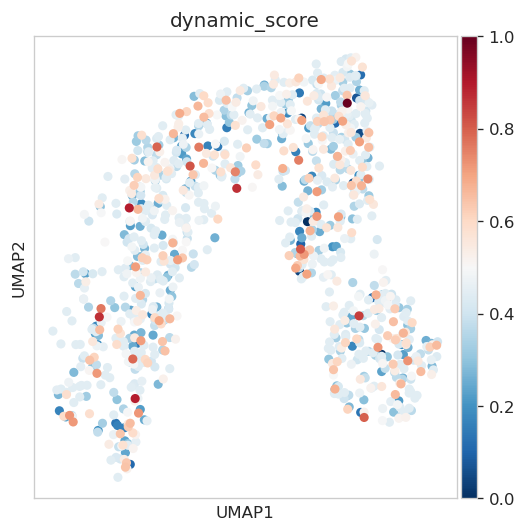

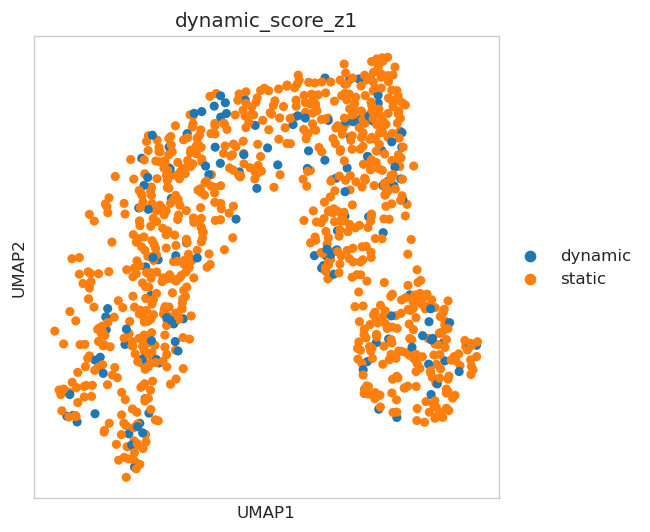

In [53]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(adata, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(adata, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)


In [54]:
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
adata.obs['dynamic_score'] = dynamic_score

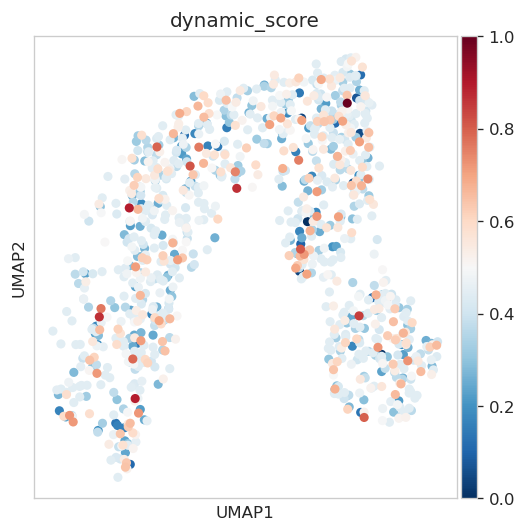

In [55]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(adata, color='dynamic_score', cmap='RdBu_r', sort_order=True)


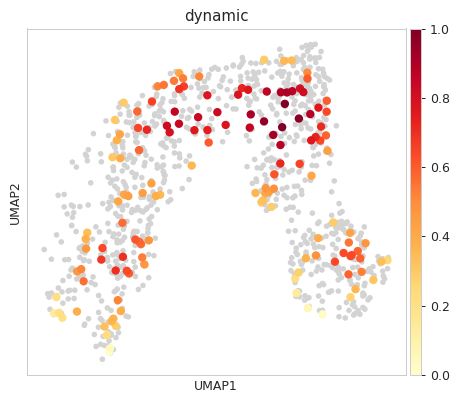

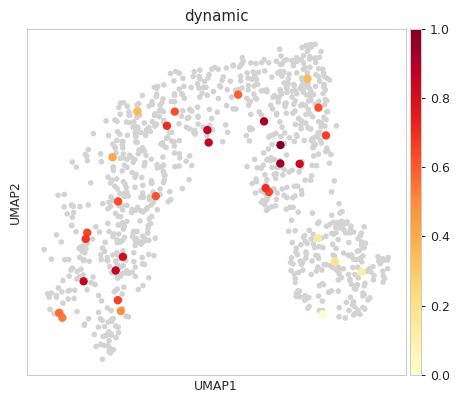

In [56]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 90
sc.tl.embedding_density(adata, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(adata, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

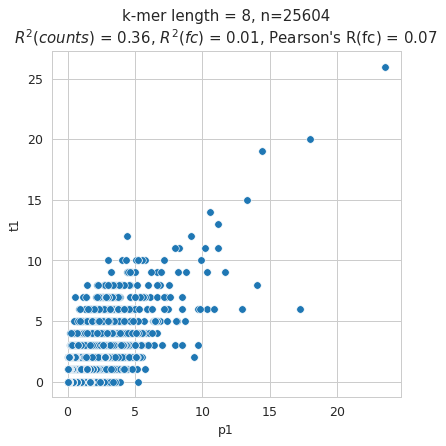

{'r2_counts': 0.36373682787498474,
 'r2_foldchange': 0.004879828938075148,
 'r2_enr': -0.04507091055165646,
 'r2_fc': 0.005412579595447148,
 'pearson_foldchange': 0.07357023579850175}

In [57]:
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)

In [58]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 4.719256
